## DRILL: Prepare the Data

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR [(Thinkful mirror)](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv).

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$
 
The 'population' variable is already set for you, but you will need to create the last three features. Robbery and Murder are currently continuous variables. For this model, please use these variables to create categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0. You'll use this data and model in a later assignment- for now, just write the code you need to get the data ready. Don't forget basic data cleaning procedures, either! Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn import linear_model
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

In [2]:
fbi = pd.read_excel('data/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', 
                    skiprows=[0,1,2,3], skipfooter=3)

In [3]:
fbi.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861,0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,2577,3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,2846,3,0,nan,0,0,3,16,1,15,0,0.000
3,Albany,97956,791,8,nan,30,227,526,4090,705,3243,142,nan
4,Albion Village,6388,23,0,nan,3,4,16,223,53,165,5,nan


In [4]:
# Check for missing values
fbi.isnull().sum()

City                                        0
Population                                  0
Violent\ncrime                              0
Murder and\nnonnegligent\nmanslaughter      0
Rape\n(revised\ndefinition)1              348
Rape\n(legacy\ndefinition)2                 0
Robbery                                     0
Aggravated\nassault                         0
Property\ncrime                             0
Burglary                                    0
Larceny-\ntheft                             0
Motor\nvehicle\ntheft                       0
Arson3                                    161
dtype: int64

All of the first rape column are missing value, so changing them would do no good.  Arson is missing 46% of it's values.  We will look into that later, since this drill is focusing on murder and robbery.

In [5]:
# check for unique items
fbi.nunique()

City                                      348
Population                                347
Violent\ncrime                             82
Murder and\nnonnegligent\nmanslaughter     14
Rape\n(revised\ndefinition)1                0
Rape\n(legacy\ndefinition)2                26
Robbery                                    51
Aggravated\nassault                        69
Property\ncrime                           239
Burglary                                  124
Larceny-\ntheft                           232
Motor\nvehicle\ntheft                      51
Arson3                                     13
dtype: int64

In [6]:
fbi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 13 columns):
City                                    348 non-null object
Population                              348 non-null int64
Violent
crime                           348 non-null int64
Murder and
nonnegligent
manslaughter    348 non-null int64
Rape
(revised
definition)1              0 non-null float64
Rape
(legacy
definition)2               348 non-null int64
Robbery                                 348 non-null int64
Aggravated
assault                      348 non-null int64
Property
crime                          348 non-null int64
Burglary                                348 non-null int64
Larceny-
theft                          348 non-null int64
Motor
vehicle
theft                     348 non-null int64
Arson3                                  187 non-null float64
dtypes: float64(2), int64(10), object(1)
memory usage: 35.4+ KB


In [7]:
# Removing Rape(legacy definite)1 as all of the values are missing
fbi_2 = fbi.drop(['Rape\n(revised\ndefinition)1'], axis=1)

fbi_2.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.000
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0.000
3,Albany,97956,791,8,30,227,526,4090,705,3243,142,nan
4,Albion Village,6388,23,0,3,4,16,223,53,165,5,nan


In [8]:
# Simply column names
fbi_2 = fbi_2.rename({'City':'city','Population':'pop','Violent\ncrime':'violent',
                     'Murder and\nnonnegligent\nmanslaughter':'murder',
                      'Rape\n(legacy\ndefinition)2':'rape','Robbery':'robbery',
                     'Aggravated\nassault':'assault','Property\ncrime':'property',
                     'Burglary':'burglary','Larceny-\ntheft':'theft',
                     'Motor\nvehicle\ntheft':'auto_theft','Arson3':'arson'}, axis='columns')

In [9]:
# Set city at index
fbi_2 = fbi_2.set_index('city')

In [10]:
fbi_2.head()

,pop,violent,murder,rape,robbery,assault,property,burglary,theft,auto_theft,arson
city,,,,,,,,,,,
Adams Village,1861,0,0,0,0,0,12,2,10,0,0.000
Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.000
Akron Village,2846,3,0,0,0,3,16,1,15,0,0.000
Albany,97956,791,8,30,227,526,4090,705,3243,142,nan
Albion Village,6388,23,0,3,4,16,223,53,165,5,nan


Let's see what our basic statistics are for each column.

In [11]:
fbi_2.describe()

,pop,violent,murder,rape,robbery,assault,property,burglary,theft,auto_theft,arson
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,187.000
mean,40037.632,201.595,1.566,5.865,72.902,121.261,792.606,119.684,637.017,35.905,1.872
std,450037.368,2815.269,18.304,60.425,1031.033,1706.132,7659.725,924.949,6346.054,403.424,10.693
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,0.000,0.000,1.000,40.500,6.000,31.000,0.000,0.000
50%,7233.500,6.000,0.000,0.000,1.000,4.000,112.500,17.500,94.000,2.000,0.000
75%,18427.500,22.000,0.000,2.000,5.000,14.000,341.000,51.250,287.250,7.000,1.000
max,8396126.000,52384.000,335.000,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000,132.000


There is obviously at least one outlier looking at the means compared to the max.  Let's see where this is coming from.

In [12]:
fbi_2.sort_values('pop', ascending=False)

,pop,violent,murder,rape,robbery,assault,property,burglary,theft,auto_theft,arson
city,,,,,,,,,,,
New York,8396126,52384,335,1112,19170,31767,141971,16606,117931,7434,nan
Buffalo,258789,3249,47,145,1322,1735,12491,3458,8076,957,nan
Rochester,210562,2107,42,92,918,1055,10051,2587,6855,609,132.000
Yonkers,199134,1036,6,25,390,615,2368,470,1662,236,10.000
Syracuse,143834,1192,21,75,400,696,6473,1781,4298,394,57.000
Amherst Town,118296,107,1,7,31,68,2118,204,1882,32,3.000
Albany,97956,791,8,30,227,526,4090,705,3243,142,nan
Greece Town,96667,151,0,9,60,82,2303,332,1925,46,nan
Ramapo Town,87204,57,2,5,9,41,567,88,466,13,nan


That makes sense as New York City is a small area with a large population and is beyond 3 standard deviations of the mean. I think separating it from the rest of the dataset would provide a better understanding of the dataset without the outlier affecting it.  

Also replacing the 'nan' in the **arson** column with the mean for that column would be helpful when we need to use that column.

In [13]:
# Change nan in arson column to mean
fbi_2.arson = fbi_2.arson.fillna((fbi_2.arson.mean()))

In [14]:
# Removing NYC from dataset
fbi_3 = fbi_2.drop('New York', axis='rows')

fbi_3.head()

,pop,violent,murder,rape,robbery,assault,property,burglary,theft,auto_theft,arson
city,,,,,,,,,,,
Adams Village,1861,0,0,0,0,0,12,2,10,0,0.000
Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0.000
Akron Village,2846,3,0,0,0,3,16,1,15,0,0.000
Albany,97956,791,8,30,227,526,4090,705,3243,142,1.872
Albion Village,6388,23,0,3,4,16,223,53,165,5,1.872


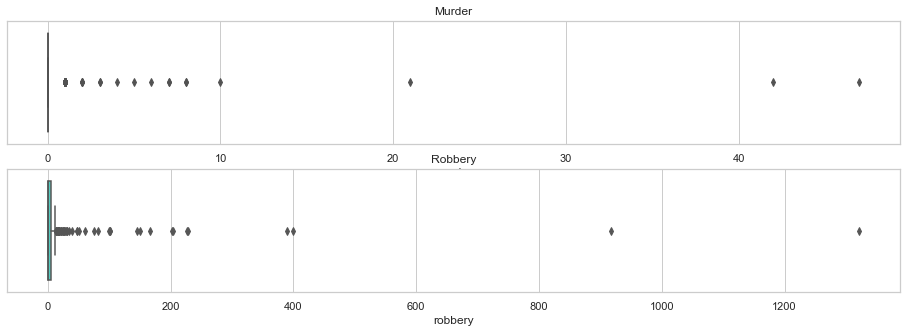

In [15]:
# Look for outliers in rows we are using for the model
sns.set(style='whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(16, 5))

# Murder
sns.boxplot(x=fbi_3['murder'], ax=axes[0], color='r').set_title('Murder')
# Robbery
sns.boxplot(x=fbi_3['robbery'], ax=axes[1], color='turquoise').set_title('Robbery')

plt.show()

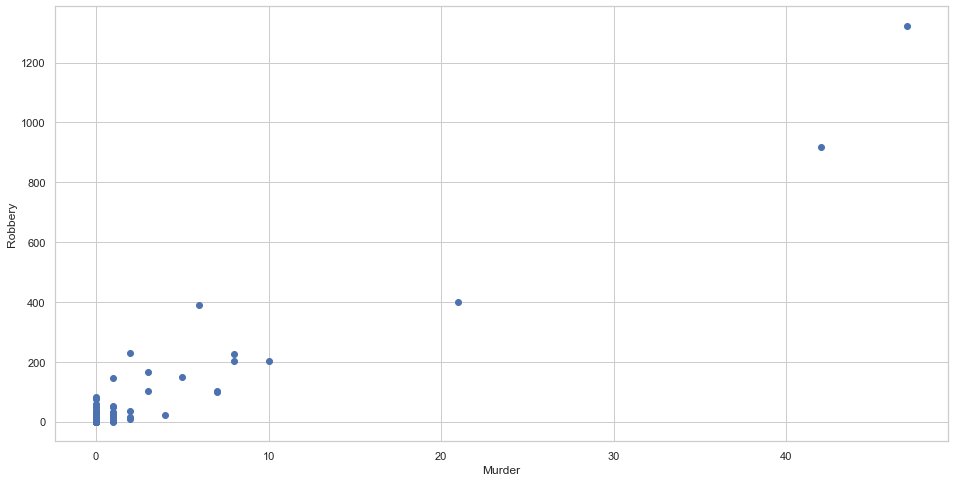

In [16]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(fbi_3['murder'], fbi_3['robbery'])
ax.set_xlabel('Murder', size=12)
ax.set_ylabel('Robbery', size=12)
plt.show()

Even with removing NYC there are still some big outliers.  Need to find another way to deal with the outliers.

There are a variety of ways to deal with outliers and I think we will bring back the dataset with NYC and normalize the murder and robbery columns.

In [ ]:
# Since both columns are int64, changing to floats
#fbi_2['murder'] = fbi_2['murder'].values.astype(float)
#fbi_2['robbery'] = fbi_2['robbery'].values.astype(float)

In [ ]:
fbi_2.head()

In [18]:
# columns to normalize
columns_to_normalize = ['murder', 'robbery']
x = fbi_2[columns_to_normalize].values.astype(float)

# create a min max processing object
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled =  min_max_scaler.fit_transform(x)

df_temp = pd.DataFrame(x_scaled, columns=columns_to_normalize,index=fbi_2.index)
fbi_2[columns_to_normalize] = df_temp

In [19]:
fbi_2.head()

,pop,violent,murder,rape,robbery,assault,property,burglary,theft,auto_theft,arson
city,,,,,,,,,,,
Adams Village,1861,0,0.000,0,0.000,0,12,2,10,0,0.000
Addison Town and Village,2577,3,0.000,0,0.000,3,24,3,20,1,0.000
Akron Village,2846,3,0.000,0,0.000,3,16,1,15,0,0.000
Albany,97956,791,0.024,30,0.012,526,4090,705,3243,142,1.872
Albion Village,6388,23,0.000,3,0.000,16,223,53,165,5,1.872


In [24]:
fbi_2.shape

(348, 11)

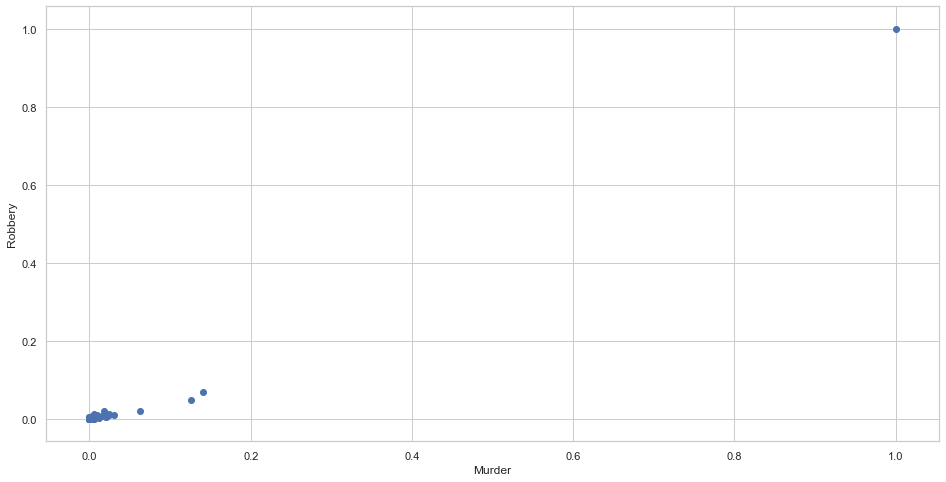

In [23]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(fbi_2['murder'], fbi_2['robbery'])
ax.set_xlabel('Murder', size=12)
ax.set_ylabel('Robbery', size=12)
plt.show()

Now the Murder and Robbery columns are normalized.  Though we still have the outliers, when they are changed to features, this will not be an issue.

Now that the outliers have been dealt with let's create the variables for our formula: $$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

In [25]:
# Adding our squared population variable

features = pd.DataFrame(fbi_2['pop'])
features['pop_sq'] = fbi_2['pop']*fbi_2['pop']
features['murder'] = np.where((fbi_2['murder'] > 0), 1, 0)
features['robbery'] = np.where((fbi_2['robbery'] > 0), 1, 0)


In [26]:
features.head()

,pop,pop_sq,murder,robbery
city,,,,
Adams Village,1861,3463321,0,0
Addison Town and Village,2577,6640929,0,0
Akron Village,2846,8099716,0,0
Albany,97956,9595377936,1,1
Albion Village,6388,40806544,0,1


In [27]:
features.shape

(348, 4)